In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [116]:
prod = pd.read_csv('Energetika/production.csv')
weather = pd.read_csv('Energetika/weather.csv')
sun = pd.read_csv('Energetika/SunSetSunRise.csv')

In [117]:
weather['Date'] = pd.to_datetime(weather['Date'])
sun['Date'] = pd.to_datetime(sun['Date'])

In [118]:
prod['Date'] = pd.to_datetime(prod['timestamp']).dt.strftime('%Y/%m/%d')
prod_agg = prod[[col for col in prod.columns if col != 'timestamp']].groupby('Date').sum().reset_index()
prod_agg['Date'] = pd.to_datetime(prod_agg['Date'])



prod_agg['Total'] = prod_agg.drop(columns=['Date']).sum(axis=1)
df = pd.merge(prod_agg[['Date', 'Total']], weather, on='Date')
df = pd.merge(df, sun[['Date', 'DaylightMinutes']], on='Date')


> Let's now look at univariate analysis and maybe try to create a model

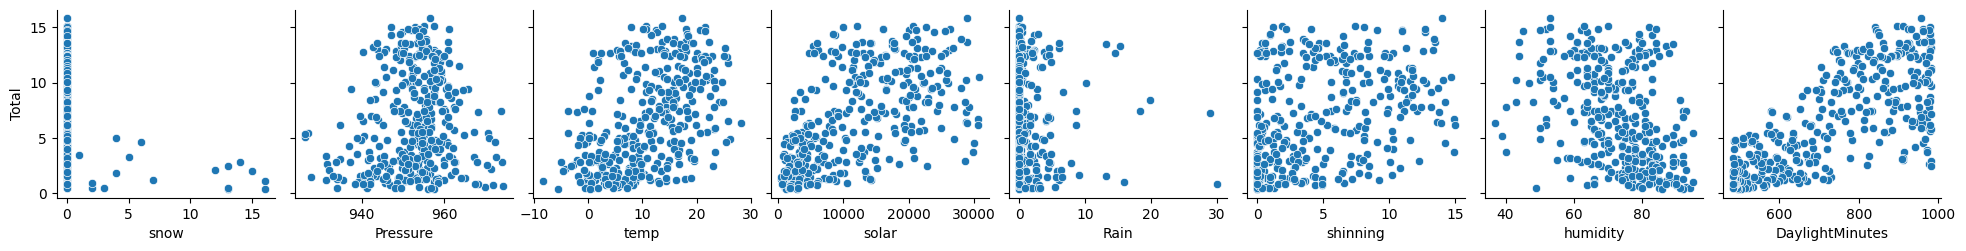

In [119]:
import seaborn as sns

# Create a pairplot to visualize relationships between 'Total' and other columns
sns.pairplot(df, y_vars='Total', x_vars=df.drop(columns=['Date', 'Total']).columns)
plt.show()

             snow    Pressure        temp         solar        Rain  \
count  365.000000  365.000000  365.000000    365.000000  365.000000   
mean     0.400000  952.646849   10.717260  11461.969863    1.339726   
std      2.151922    8.329800    7.518099   8354.035828    3.394515   
min      0.000000  926.200000   -8.400000    478.000000    0.000000   
25%      0.000000  948.800000    5.200000   3637.000000    0.000000   
50%      0.000000  953.700000   10.500000   9906.000000    0.000000   
75%      0.000000  957.500000   16.600000  18124.000000    1.100000   
max     16.000000  974.200000   28.200000  30743.000000   30.000000   

        shinning    humidity  DaylightMinutes  
count  365.00000  365.000000       365.000000  
mean     4.58137   73.019178       735.747945  
std      4.37161   11.538620       169.843794  
min      0.00000   37.000000       485.000000  
25%      0.40000   66.000000       573.000000  
50%      3.40000   75.000000       738.000000  
75%      7.80000   81.00

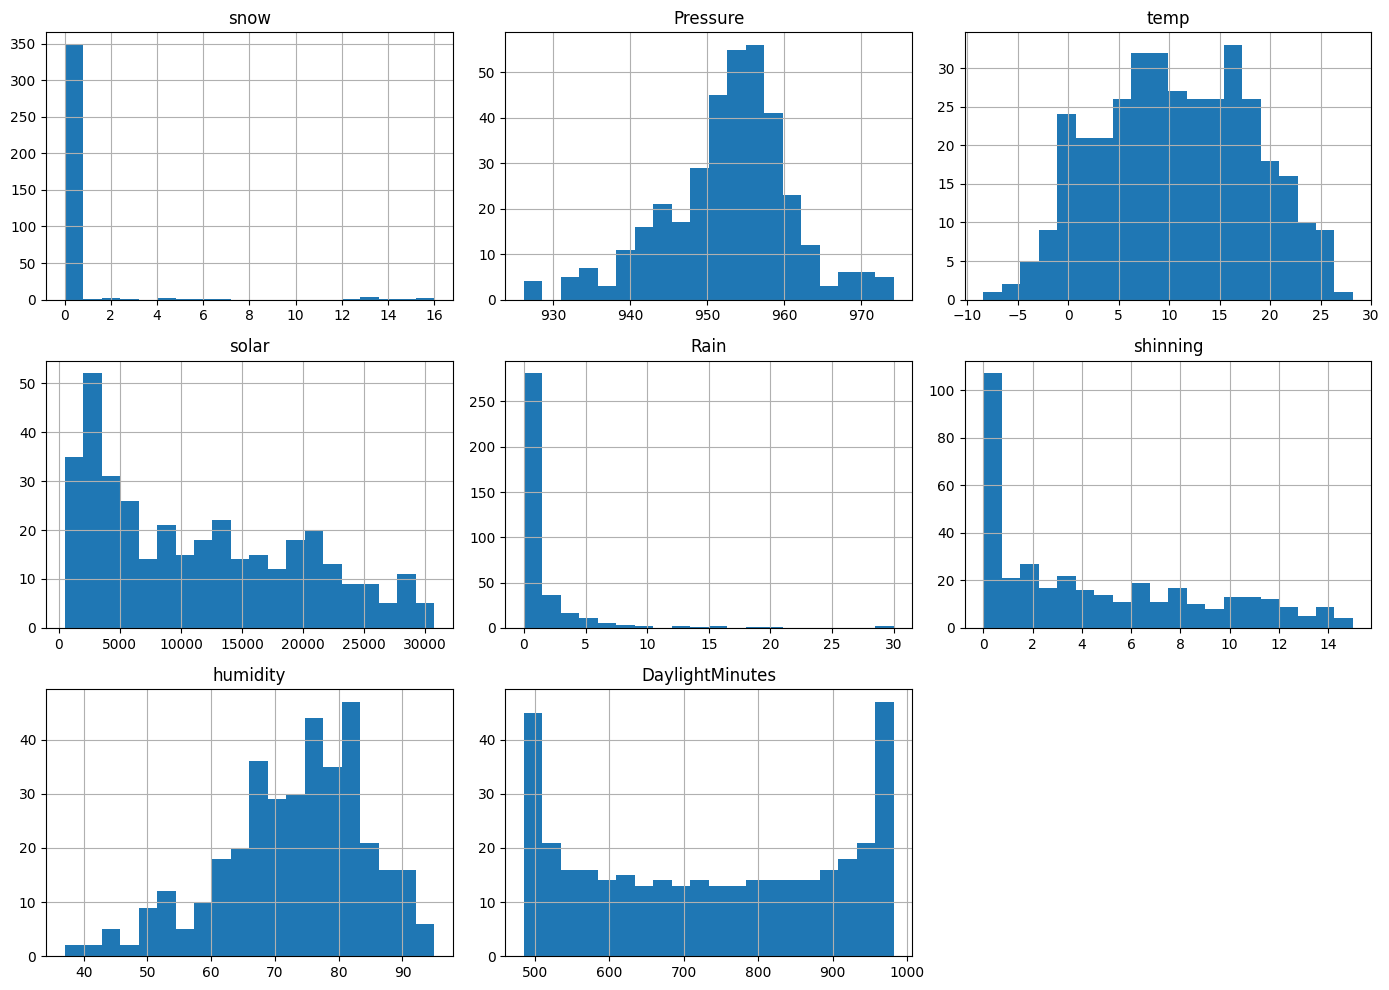

In [120]:
# Summary statistics
summary_stats = df.drop(columns=['Total', 'Date']).describe()
print(summary_stats)

# Histograms for each variable
df.drop(columns=['Total', 'Date']).hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

### Comment

- From here we can exclude snow, because of lack of variability, rain for the same reason

In [121]:
df = df.drop(columns=['Rain', 'snow'])

## Using linear regression to try to predict Total production

Firstly we tried to look at all the variables that went into model selection and recursively removed non-significant features. We added lagged variable because it is logical to assume that best predictor of total production a yesterdays values.

In [122]:
# add lagged total as a feature
df['Total_lagged'] = df['Total'].shift(1)
df = df.dropna()

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df[['temp', 'DaylightMinutes', 'Total_lagged']]
y = df['Total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse.round(2)}')
print(f'R^2 Score: {np.round(r2, 2)}')

Mean Squared Error: 6.04
R^2 Score: 0.72


In [132]:
import statsmodels.api as sm

def create_and_fit_model(df, preds, target):

    X = df[preds]
    y = df[target]
    X_sm = sm.add_constant(X)
    model_sm = sm.OLS(y, X_sm).fit()
    print('-'*78)
    print(f'Model for {preds} predicting {target}')
    print('-'*78)
    print(model_sm.summary())
    print('-'*78)
    return model_sm

preds = [['temp', 'DaylightMinutes', 'Total_lagged'], ['DaylightMinutes', 'Total_lagged'], ['temp', 'DaylightMinutes'], ['temp', 'Total_lagged'], ['temp'], ['DaylightMinutes'], ['Total_lagged']]

for pred in preds:
    create_and_fit_model(df, pred, 'Total')


------------------------------------------------------------------------------
Model for ['temp', 'DaylightMinutes', 'Total_lagged'] predicting Total
------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     182.5
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           6.34e-72
Time:                        00:01:46   Log-Likelihood:                -888.05
No. Observations:                 364   AIC:                             1784.
Df Residuals:                     360   BIC:                             1800.
Df Model:                           3                                         
Covariance Type:            nonrobust                       

### Comment

- We arrived at a model consisting of `Lagged_Total`, `Temperature`, `DaylightMinutes`.
  - `Lagged_Total`    = lagged value of total production
  - `Temperature`     = average temperature of a day
  - `DaylightMinutes` = Difference between sunrise and sunset in minutes
- All of the parameters are significant (p-value < 0.05)
- Model has a $R^2$ equal to $0.6$ which tells us that $60%$ of variation can be explained by the model
- We could also choose only model consisting of `DaylightMinutes` and `Lagged_Total`.

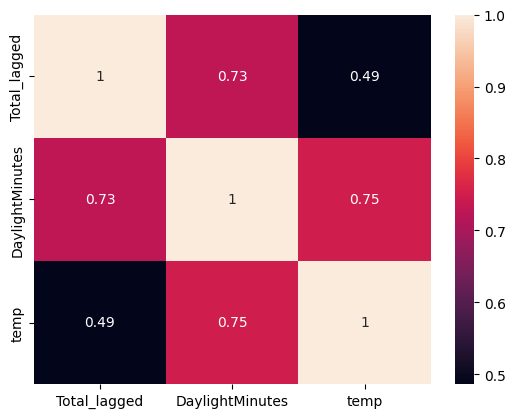

In [126]:
# Show correlation matrix

corr = df[['Total_lagged', 'DaylightMinutes', 'temp']].corr()
sns.heatmap(corr, annot=True)
plt.show()

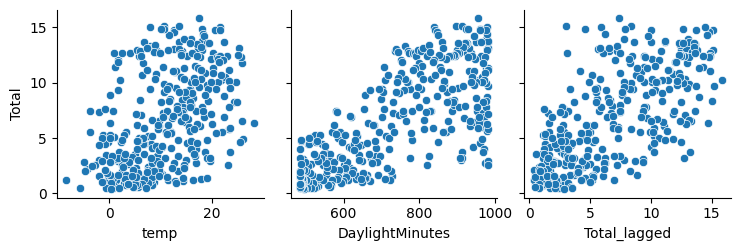

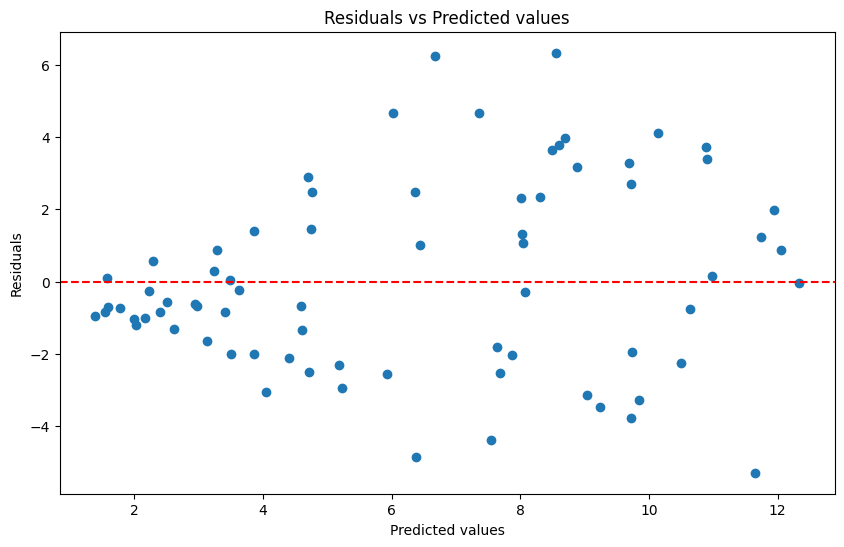

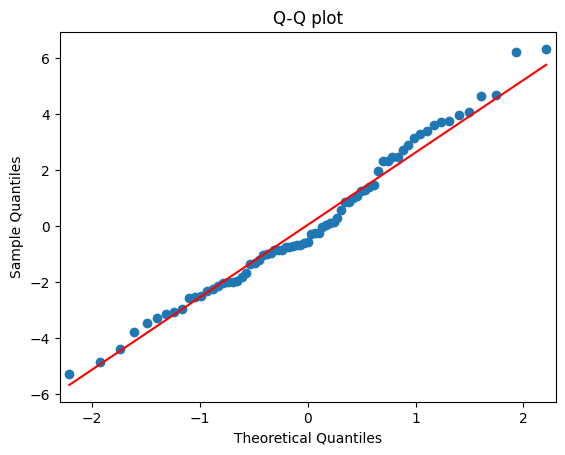

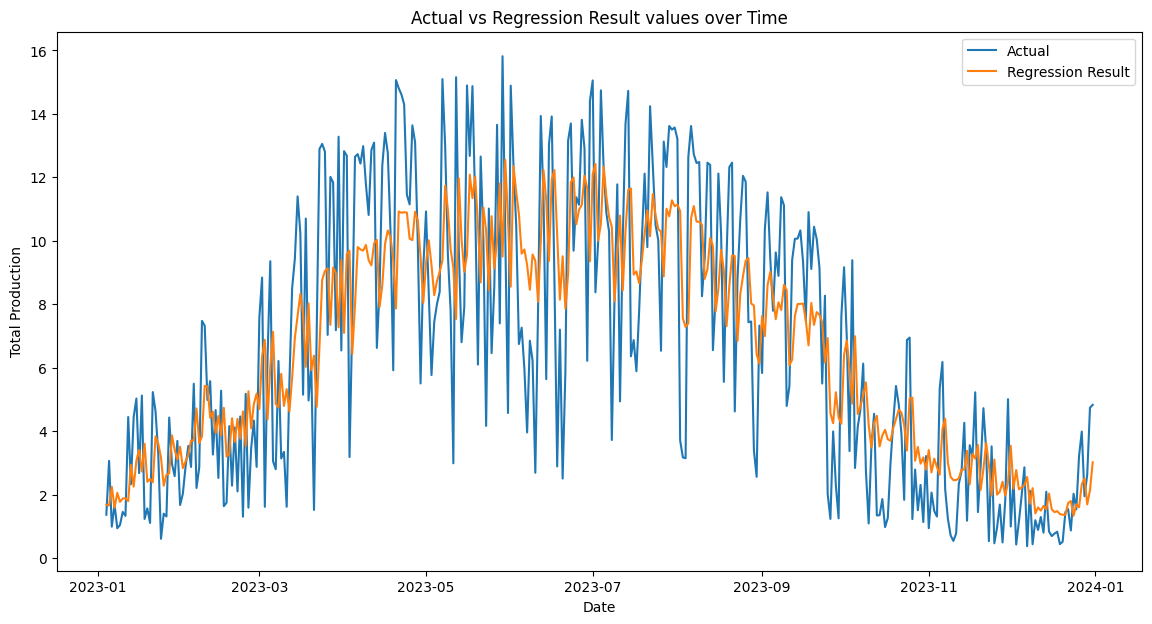

In [ ]:
import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt

sns.pairplot(df, y_vars='Total', x_vars=['temp', 'DaylightMinutes', 'Total_lagged'])
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()


sm.qqplot(y_test - y_pred, line='s')
plt.title('Q-Q plot')
plt.show()


df['RegressionResult'] = model.predict(df[['temp', 'DaylightMinutes', 'Total_lagged']])

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Total'], label='Actual')
plt.plot(df['Date'], df['RegressionResult'], label='Regression Result')
plt.legend()
plt.title('Actual vs Regression Result values over Time')
plt.xlabel('Date')
plt.ylabel('Total Production')
plt.show()

### Comment

- As we can see predictors are highly correlated, which makes perfect sense in our use case (In winter we have shorter days, lower temperature and also lower production of energy from solar panel the day before). In this case we lose ability to explain predictors impact, but this was not the point.
- As we can see on second and third plot residuals are normally distributed
- On the last plot we see how our prediction is less volatile than actual values.

> The plot of predicted x actual values is not very smooth so for better picture we used weekly rolling average to smooth the plot a little.

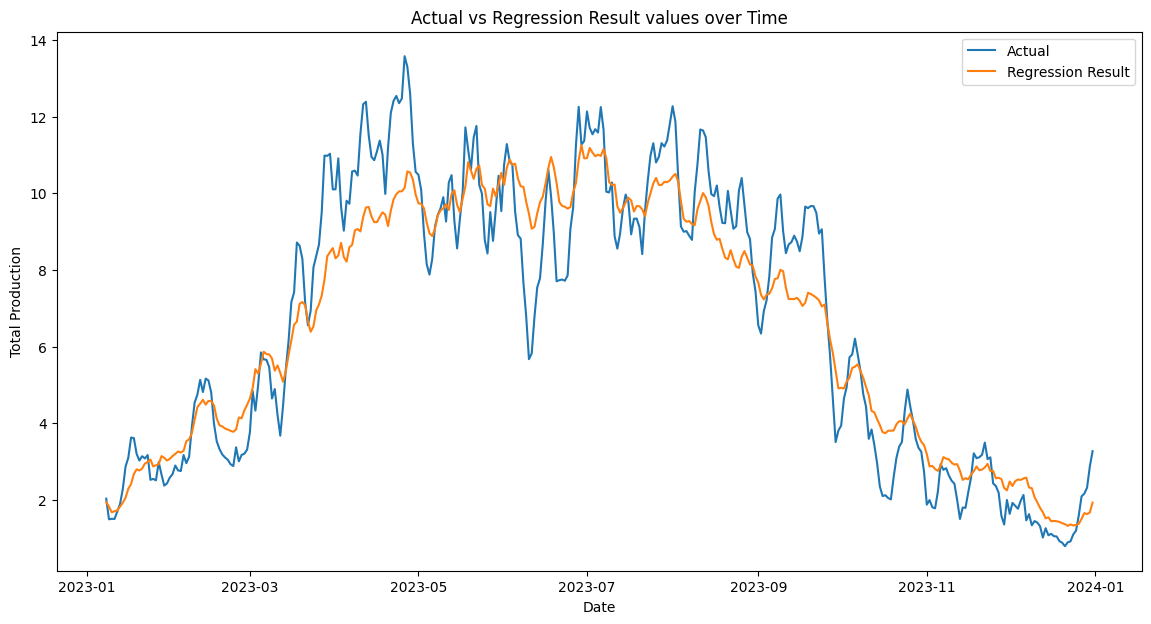

In [134]:
df['RegressionResult'] = model.predict(df[['temp', 'DaylightMinutes', 'Total_lagged']])


df['Total_MA'] = df['Total'].rolling(window=7).mean()
df['RegressionResult_MA'] = df['RegressionResult'].rolling(window=7).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Total_MA'], label='Actual')
plt.plot(df['Date'], df['RegressionResult_MA'], label='Regression Result')
plt.legend()
plt.title('Actual vs Regression Result values over Time')
plt.xlabel('Date')
plt.ylabel('Total Production')
plt.show()